In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns

In [3]:
mv_grid_ids = [176, 177, 1056, 1690, 1811, 2534]
results_path = r"U:\Software\eDisGo_object_files\simbev_nep_2035_results"

In [4]:
# get data for all representatives

cols = ["PV", "Wind", "Other generation", "Conv. load and heat pumps", "Electromobility"]
df = pd.DataFrame(columns=cols, index=mv_grid_ids)

for mv_grid_id in mv_grid_ids:
    
    # load topology data
    grid_path = os.path.join(results_path, str(mv_grid_id),'dumb', "topology")
    generators_csv = os.path.join(grid_path, "generators.csv")
    generators_df = pd.read_csv(generators_csv, index_col=[0])
    loads_csv = os.path.join(grid_path, "loads.csv")
    loads_df = pd.read_csv(loads_csv, index_col=[0])
    charging_points_csv = os.path.join(grid_path, "charging_points.csv")
    charging_points_df = pd.read_csv(charging_points_csv, index_col=[0])
    
    # calculate values
    df.at[mv_grid_id, "PV"] = generators_df[generators_df.type == "solar"].p_nom.sum()
    df.at[mv_grid_id, "Wind"] = generators_df[generators_df.type == "wind"].p_nom.sum()
    df.at[mv_grid_id, "Other generation"] = generators_df[~generators_df.type.isin(["solar", "wind"])].p_nom.sum()
    df.at[mv_grid_id, "Conv. load and heat pumps"] = loads_df.peak_load.sum()
    df.at[mv_grid_id, "Electromobility"] = charging_points_df.p_nom.sum()

In [40]:
df.loc[[177,2534,176,1056,1811,1690]]

,PV,Wind,Other generation,Conv. load and heat pumps,Electromobility
177,23.5816,0,0.491826,49.6121,68.1038
2534,17.9948,0,0,65.0652,37.709
176,60.638,6.277,15.4359,40.0159,72.4737
1056,99.1748,8.311,2.74195,14.2187,28.8881
1811,23.6148,125.35,26.4879,15.7176,39.6904
1690,38.3881,138.173,50.0522,15.3738,28.1895


In [8]:
columns_load = ["Conv. load and heat pumps", "Electromobility"]
columns_generation = ["PV", "Wind", "Other generation"]
cols = columns_generation.copy()
cols.extend(columns_load)

In [9]:
# make generation negative values
df.loc[:, columns_load] = df.loc[:, columns_load] * -1

In [10]:
# calculate total installed capacity to sort by
#df["summe"] = df.loc[:, columns_generation].sum(axis=1)
#df = df.sort_values(by=['summe'], ascending=True)

ind = [1690, 1811, 1056, 176, 2534, 177]
df = df.loc[ind[::-1], :]

In [25]:
def bar_plot_plotly(df, save_fig=False, title=False):
    plt.figure(figsize=(12,10))
    plt.subplots_adjust(bottom=0.2, left=0.2)
    sns.set()
    df.plot.barh(
        stacked = True,
        color=['yellow', 'blue', 'green', 'red', 'orange']
    )
    plt.grid(b=True, which='major', axis='x', alpha=0.5, linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', axis='x', alpha=0.3, linestyle='--')
    plt.legend(['PV', 'Wind', 'Other generation', 'Conventional Load', 'Mobility'])
    plt.xlabel('Installed capacity / Peak load in MW ')
    plt.ylabel('Grid ID')
    if title:
        plt.title(title)
    if save_fig:
        plt.savefig("Installed_cap_peak_load_representatives.png", dpi=150)
    plt.show()

## Make plot for cluster representatives

<Figure size 864x720 with 0 Axes>

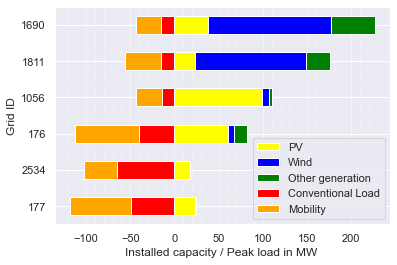

In [11]:
bar_plot_plotly(df.loc[:, cols])

In [47]:
df

,PV,Wind,Other generation,Conv. load and heat pumps,Electromobility
177,23.5816,0,0.491826,-49.6121,-68.1038
2534,17.9948,0,0,-65.0652,-37.709
176,60.638,6.277,15.4359,-40.0159,-72.4737
1056,99.1748,8.311,2.74195,-14.2187,-28.8881
1811,23.6148,125.35,26.4879,-15.7176,-39.6904
1690,38.3881,138.173,50.0522,-15.3738,-28.1895


In [37]:
def bar_plot_plotly_adapted(df, save_fig=False, title=False):
    plt.figure(figsize=(2,4))
    plt.subplots_adjust(bottom=0.2, left=0.2)
    sns.set()
    sns.set_style("whitegrid")
    ax=df[['Conv. load and heat pumps', 'Electromobility']].plot.barh(
        stacked = True,
        color=['dimgrey', 'black'], 
        hatch="\\"
    )
    df[['PV', 'Wind', 'Other generation']].plot.barh(
        stacked = True,
        color=['darkgrey', 'lightgrey', 'grey'], ax=ax,
        hatch="///"
    ), 
    plt.grid(b=True, which='major', axis='x', alpha=0.5, linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', axis='x', alpha=0.3, linestyle='--')
    plt.legend(['Conv. load \n(incl. HPs)', 'EVs', 'PV', 'Wind', 'dRES'])
    handles, labels = plt.gca().get_legend_handles_labels()
    labels=['Conv. load \n(incl. HPs)', 'EVs', 'PV', 'Wind', 'dRES']
    handles, labels = zip(*[ (handles[i], labels[i]) for i in [1,0,2,3,4]] )
    plt.legend(handles, labels)
    plt.xlabel('                  Peak load / Installed capacity in MW', loc='left')
    plt.ylabel('Grid ID')
    y_ticklabels = ['$1690_W$', '$1811_W$', '$1056_{PV}$', '$176_{PV}$', '$2534_{L}$', '$177_{L}$']
    y_ticklabels.reverse()
    ax.set_yticklabels(y_ticklabels)
    ax.set_xticklabels(['150', '100', '50', '0', '50', '100', '150', '200', '250'])
    plt.tight_layout()
    if title:
        plt.title(title)
    if save_fig:
        plt.savefig("Installed_cap_peak_load_representatives.png", dpi=300)
    plt.show()

<Figure size 144x288 with 0 Axes>

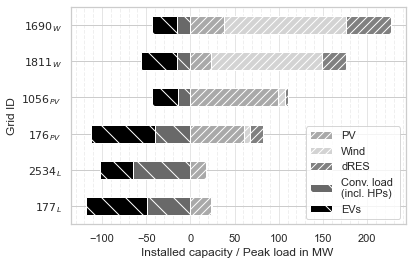

In [89]:
bar_plot_plotly_adapted(df.loc[:, cols], save_fig=True)

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\ipykernel_launcher.py:29: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 144x288 with 0 Axes>

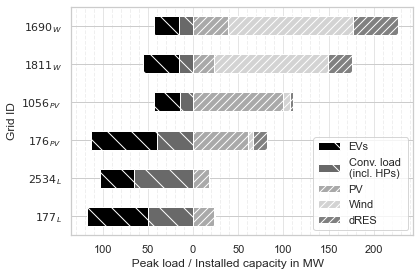

In [38]:
bar_plot_plotly_adapted(df.loc[:, cols], save_fig=True)

In [87]:
y_ticklabels = ['$1690_W$', '$1811_W$', '$1056_{PV}$', '$176_{PV}$', '$2534_{L}$', '$177_{L}$']
y_ticklabels.reverse()
y_ticklabels

AttributeError: 'list' object has no attribute 'reversed'

<Figure size 864x720 with 0 Axes>

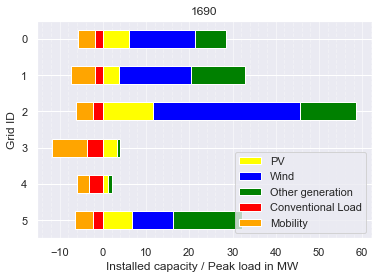

<Figure size 864x720 with 0 Axes>

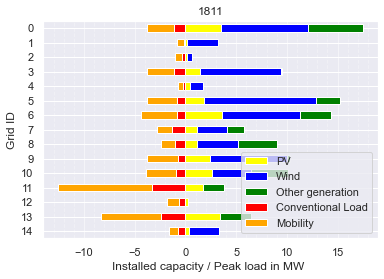

<Figure size 864x720 with 0 Axes>

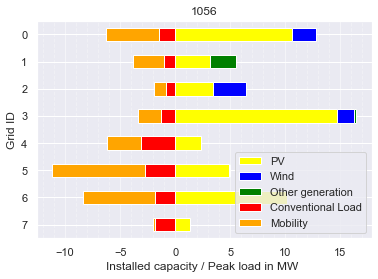

<Figure size 864x720 with 0 Axes>

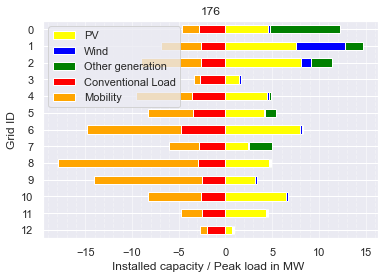

<Figure size 864x720 with 0 Axes>

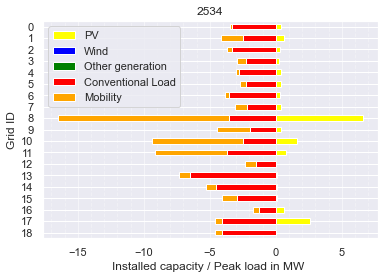

<Figure size 864x720 with 0 Axes>

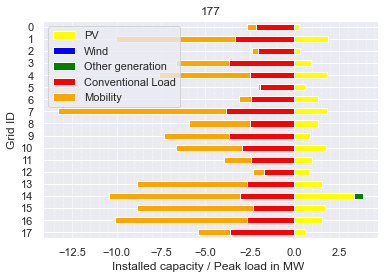

In [28]:
for grid_id in [1690, 1811, 1056, 176, 2534, 177]:
    feeders = os.listdir(os.path.join(results_path, str(grid_id),'feeder'))
    # get data for all representatives

    cols = ["PV", "Wind", "Other generation", "Conv. load and heat pumps", "Electromobility"]
    df = pd.DataFrame(columns=cols, index=feeders)
    for feeder in feeders:
        # load topology data
        grid_path = os.path.join(results_path, str(grid_id),'feeder', feeder, "topology")
        generators_csv = os.path.join(grid_path, "generators.csv")
        generators_df = pd.read_csv(generators_csv, index_col=[0])
        loads_csv = os.path.join(grid_path, "loads.csv")
        loads_df = pd.read_csv(loads_csv, index_col=[0])
        charging_points_csv = os.path.join(grid_path, "charging_points.csv")
        charging_points_df = pd.read_csv(charging_points_csv, index_col=[0])

        # calculate values
        df.at[feeder, "PV"] = generators_df[generators_df.type == "solar"].p_nom.sum()
        df.at[feeder, "Wind"] = generators_df[generators_df.type == "wind"].p_nom.sum()
        df.at[feeder, "Other generation"] = generators_df[~generators_df.type.isin(["solar", "wind"])].p_nom.sum()
        df.at[feeder, "Conv. load and heat pumps"] = loads_df.peak_load.sum()
        df.at[feeder, "Electromobility"] = charging_points_df.p_nom.sum()
    columns_load = ["Conv. load and heat pumps", "Electromobility"]
    columns_generation = ["PV", "Wind", "Other generation"]
    cols = columns_generation.copy()
    cols.extend(columns_load)
    # make generation negative values
    df.loc[:, columns_load] = df.loc[:, columns_load] * -1
    ind = [str(tmp) for tmp in sorted([int(feeder) for feeder in feeders])]
    df = df.loc[ind[::-1], :]
    bar_plot_plotly(df.loc[:, cols], title=str(grid_id))

In [23]:
sorted([int(feeder) for feeder in feeders])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]